In [1]:
import glob

import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
import config
import data
import random
from natsort import natsorted
arm = 'UR5'
PYBULLET_DATA_DIR = config.ONEOBJ_PLAY # config.SCRIPTED_PLAY #config.RPL_PATH
if arm == 'UR5':
    PYBULLET_DATA_DIR = config.UR5
    TEST_DIR = config.UR5_TEST

In [2]:
physical_devices = tf.config.list_physical_devices(config.DEVICE)
if config.DEVICE is 'GPU':
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
# 
RELATIVE = False # use relative joints instead of absolute pos/ori as in the original paper
QUAT =  False # whether to use quaternions or rpy in actions
JOINTS = False # use relative joints instead of absolute angles
VELOCITY = False
USE_QUAT_OBS = False

LAYER_SIZE = 2048
LATENT_DIM = LAYER_SIZE//8
GRIPPER_WEIGHT = 5.0
GCBC = False
PROBABILISTIC = False

arm = 'UR5'



In [4]:
#dataset, cnt = data.create_single_dataset(dataset_path)
rpy_obs = 'obs_rpy' #'rpy_obs'
def load_data(path, keys):
    dataset = {k:[] for k in keys+['sequence_index','sequence_id']}
    obs_act_path = os.path.join(path, 'obs_act_etc/')

    for demo in natsorted(os.listdir(obs_act_path)):
        print(demo)
        traj = np.load(obs_act_path+demo+'/data.npz')
        for k in keys:
            dataset[k].append(traj[k].astype(np.float32))
        timesteps = len(traj['obs'])
        dataset['sequence_index'].append(np.arange(timesteps, dtype=np.int32).reshape(-1, 1))
        dataset['sequence_id'].append(np.full(timesteps, fill_value=int(demo), dtype=np.int32).reshape(-1, 1))

    # convert to numpy
    for k in keys+['sequence_index','sequence_id']:
        dataset[k] = np.vstack(dataset[k])
    return dataset

In [5]:
keys = ['obs', 'acts', 'achieved_goals', 'joint_poses', 'target_poses', 'acts_rpy', 'acts_rpy_rel',  'velocities', rpy_obs]
dataset = load_data(PYBULLET_DATA_DIR, keys)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


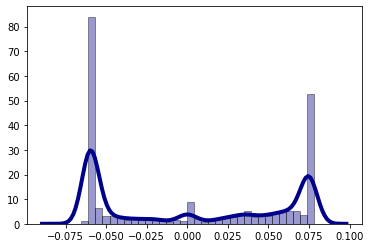

In [6]:
import seaborn as sns
#for i in range(0,dataset[rpy_obs].shape[1]):
sns.distplot(dataset['achieved_goals'][:,7], hist=True, kde=True, 
         bins=int(180/5), color = 'darkblue', 
         hist_kws={'edgecolor':'black'},
         kde_kws={'linewidth': 4})
plt.show()

In [7]:

if JOINTS:
    OBS_DIM = dataset['obs'].shape[1] + 7 
    ACT_DIM = dataset['target_poses'].shape[1] + 1
else:
    if USE_QUAT_OBS:
      OBS_DIM = dataset['obs'].shape[1]
    else:
      OBS_DIM = dataset[rpy_obs].shape[1]
    
    if QUAT:
        ACT_DIM = dataset['acts'].shape[1]
    else:
        ACT_DIM = dataset['acts_rpy'].shape[1]

if VELOCITY:
    OBS_DIM += dataset['velocities'].shape[1]
        
GOAL_DIM = dataset['achieved_goals'].shape[1]
print(f'Obs: (N,{OBS_DIM}), Acts: (N,{ACT_DIM}), Goals: (N,{GOAL_DIM})')

Obs: (N,18), Acts: (N,7), Goals: (N,11)


In [8]:
DATASET_SIZE = dataset['obs'].shape[0]
secs = DATASET_SIZE / 25
hours = secs // 3600
minutes = secs // 60 - hours * 60
print(f"We have {DATASET_SIZE} frames of data, which is {hours:.0f}hrs {minutes:.0f}m.")

We have 242268 frames of data, which is 2hrs 41m.


In [9]:
import pybullet
BATCH_SIZE_PER_REPLICA = 32
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA

WINDOW_SIZE = 50
MIN_WINDOW_SIZE = WINDOW_SIZE//2
WINDOW_SHIFT = 1
SHUFFLE_SIZE = GLOBAL_BATCH_SIZE*100
PREFETCH_SIZE = tf.data.experimental.AUTOTUNE
NUM_WORKERS = 4
TRAIN_TEST_SPLIT = 0.9
VARIABLE_SEQ_LENS = True

window_lambda = lambda x: tf.data.Dataset.zip(x).batch(WINDOW_SIZE)
seq_overlap_filter = lambda x: tf.equal(tf.size(tf.unique(tf.squeeze(x['sequence_id'])).y), 1)

def create_goal_tensor(dataset, seq_len=-1):
    ''' Tile final achieved_goal across time dimension '''
    tile_dims = tf.constant([WINDOW_SIZE, 1], tf.int32)
    goal = tf.tile(dataset['achieved_goals'][seq_len-1,tf.newaxis], tile_dims) # as goal is at an index take seq_len -1
    return goal

def transform_states(dataset):
    if JOINTS:
        if RELATIVE:
          if arm == 'UR5':
              rel = dataset['target_poses'] - dataset['joint_poses'][:,:6] 
          else:
              rel = dataset['target_poses'] - dataset['joint_poses'][:,:7]
        else:
          rel = dataset['target_poses']

        gripper = dataset['acts'][:,-1,tf.newaxis]
        acts = tf.concat([rel, gripper], axis=-1)
        obs = tf.concat([dataset['obs'],dataset['joint_poses'][:,:7]], axis=-1)#.astype('float32')
    else:
        if USE_QUAT_OBS:
          obs = dataset['obs']
        else:
          obs = dataset[rpy_obs]
        
        
        if RELATIVE:
            if QUAT:
                rel = dataset['acts'][:,:7] - dataset['obs'][:,:7]
            else:
                rel = dataset['acts_rpy'][:,:6] - dataset[rpy_obs][:,:6]
                
            gripper = dataset['acts'][:,-1,tf.newaxis]
            acts = tf.concat([rel, gripper], axis=-1)
        else:
            if QUAT:
                acts = dataset['acts']
            else:
                acts = dataset['acts_rpy']

    if VELOCITY:
      obs = tf.concat([obs, dataset['velocities']], axis = -1)
    
    # Variable Seq len
    if VARIABLE_SEQ_LENS:
      seq_len = tf.random.uniform(shape=[], minval=MIN_WINDOW_SIZE, maxval=WINDOW_SIZE, dtype=tf.int32, seed=10)
    else:
      seq_len = WINDOW_SIZE # SEQLENS Just at max window size

    print(obs.shape)
    mask = tf.cast(tf.sequence_mask(seq_len, maxlen=WINDOW_SIZE), tf.float32) # creates a B*T mask
    multiply_mask = tf.expand_dims(mask, -1)

    goals = create_goal_tensor(dataset, seq_len)

    obs = obs * multiply_mask
    acts = acts * multiply_mask
    goals = goals * multiply_mask
    
    ags = dataset['achieved_goals'] * multiply_mask
    ag_to_goal = abs(ags - goals)
    print(multiply_mask)
    r = (1.0-tf.cast((tf.reduce_mean(tf.cast(ag_to_goal > 0.05, tf.float32), -1) > 0), tf.float32)) * tf.squeeze(multiply_mask)
    
    

    

    return {'obs':obs, 'acts':acts, 'goals':goals, 'seq_lens': tf.cast(seq_len, tf.float32), 'masks':mask, 
           'dataset_path':dataset['sequence_id'], 'tstep_idxs':dataset['sequence_index'], 'ags': ags ,
            'reward': ag_to_goal, 'reward': r}

def tf_ds_transform(dataset):
    return dataset\
                .window(size=WINDOW_SIZE, shift=WINDOW_SHIFT, stride=1, drop_remainder=True)\
                .flat_map(window_lambda)\
                .filter(seq_overlap_filter)\
                .shuffle(SHUFFLE_SIZE)\
                .repeat()\
                .map(transform_states, num_parallel_calls=NUM_WORKERS)\
                .batch(GLOBAL_BATCH_SIZE, drop_remainder=True)\
                .prefetch(PREFETCH_SIZE)\
                # .cache()

# Todo: Need to confirm splitting here works with shuffle() and repeat()
train_size = int(TRAIN_TEST_SPLIT * DATASET_SIZE)

full_dataset = tf.data.Dataset.from_tensor_slices(dataset)
train_dataset = tf_ds_transform(full_dataset.take(len(full_dataset)))

valid_dataset = load_data(TEST_DIR, keys)
valid_dataset = tf.data.Dataset.from_tensor_slices(valid_dataset)
valid_dataset = tf_ds_transform(valid_dataset.take(len(valid_dataset)))
train_dataset

(None, 18)
Tensor("ExpandDims:0", shape=(50, 1), dtype=float32)
0
1
2
3
4
5
6
7
8
(None, 18)
Tensor("ExpandDims:0", shape=(50, 1), dtype=float32)


<PrefetchDataset shapes: {obs: (32, 50, 18), acts: (32, 50, 7), goals: (32, 50, 11), seq_lens: (32,), masks: (32, 50), dataset_path: (32, None, 1), tstep_idxs: (32, None, 1), ags: (32, 50, 11), reward: (32, 50)}, types: {obs: tf.float32, acts: tf.float32, goals: tf.float32, seq_lens: tf.float32, masks: tf.float32, dataset_path: tf.int32, tstep_idxs: tf.int32, ags: tf.float32, reward: tf.float32}>

In [10]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Input, LSTM, Concatenate, Masking, Reshape, Lambda
from tensorflow.keras.regularizers import l1, l2
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

In [11]:
from custom_layers import LearnedInitLSTM

In [12]:

def latent_normal(inputs):
    mu, scale = inputs
    dist = tfd.Normal(loc=mu, scale=scale)
    return dist


def logistic_mixture(inputs):
    weightings, mu, scale = inputs
    dist = tfd.Logistic(loc=mu, scale=scale)
    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=weightings),
        components_distribution=dist,
        validate_args=True
    )
    return mixture_dist

def create_actor(layer_size=1024, latent_dim = 256, epsilon=1e-4, num_distribs=None, GCBC=False, training=True, return_state=False):
    # params #
    batch_size = None if training else 1
    stateful = not training

    # Input #
    o = Input(shape=(None, OBS_DIM), batch_size=batch_size, dtype=tf.float32, name='input_obs')
    z = Input(shape=(None, latent_dim), batch_size=batch_size, dtype=tf.float32, name='input_latent')
    g = Input(shape=(None, GOAL_DIM), batch_size=batch_size, dtype=tf.float32, name='input_goals')

    # RNN #
    if GCBC:      
      x =  Concatenate(axis=-1)([o,g])
    else:
      x =  Concatenate(axis=-1)([o,z,g])

    x = Masking(mask_value=0.)(x)
    if return_state:
#         x, _, state1 = LearnedInitLSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_1', return_state=return_state)(x)
#         x, _, state2= LearnedInitLSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_2', return_state=return_state)(x)
        x, _, state1 = LSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_1', return_state=return_state)(x)
        x, _, state2= LSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_2', return_state=return_state)(x)
    else:
#         x = LearnedInitLSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_1', return_state=return_state)(x)
#         x = LearnedInitLSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_2', return_state=return_state)(x)
        x = LSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_1', return_state=return_state)(x)
        x = LSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_2', return_state=return_state)(x)
    # Probabilistic Mixture Model #
    if num_distribs:
        weightings = Dense(ACT_DIM*num_distribs, activation=None, name='alpha')(x)
        mu = Dense(ACT_DIM*num_distribs, activation=None, name='mu')(x)
        scale = Dense(ACT_DIM*num_distribs, activation="softplus", name='sigma')(x + epsilon)

        weightings = Reshape((-1, ACT_DIM, num_distribs))(weightings)
        mu = Reshape((-1, ACT_DIM, num_distribs))(mu)
        scale = Reshape((-1, ACT_DIM, num_distribs))(scale)
        
        actions = tfpl.DistributionLambda(logistic_mixture, name='logistic_mix')([weightings, mu, scale])
    else:
        actions = Dense(ACT_DIM, activation=None, name='acts')(x)
    
    if return_state:
        if GCBC:
          return Model([o, g], [actions, state1, state2])
        else:
          return Model([o, z, g], [actions, state1, state2])
    else:
        if GCBC:
          return Model([o, g], actions)
        else:
          return Model([o, z, g], actions)


In [13]:
from tensorflow.keras.layers import Bidirectional


def create_encoder(layer_size=2048, latent_dim = 256, epsilon=1e-4, training=True):
    # Input #
    obs = Input(shape=(WINDOW_SIZE, OBS_DIM), dtype=tf.float32, name='obs')
    acts = Input(shape=(WINDOW_SIZE, ACT_DIM), dtype=tf.float32, name='acts') 

    # Layers #
    x = Concatenate(axis=-1)([obs, acts])
    x = Masking(mask_value=0.)(x)
    x = Bidirectional(LSTM(layer_size//4, return_sequences=True), merge_mode='concat')(x)
    x = Bidirectional(LSTM(layer_size//4, return_sequences=False), merge_mode='concat')(x)

    # Latent Variable # 
    mu = Dense(latent_dim, activation=None, name='mu')(x)
    scale = Dense(latent_dim, activation="softplus", name='sigma')(x + epsilon)
    
    mixture = tfpl.DistributionLambda(latent_normal, name='latent_variable')((mu, scale))
    return Model([obs, acts], mixture)


def create_planner(layer_size=2048, latent_dim = 256, epsilon=1e-4, training=True):
    # params #
    batch_size = None

    # Input #
    o_i = Input(shape=(OBS_DIM,), batch_size=batch_size, dtype=tf.float32, name='initial_obs') # has arm state
    o_g = Input(shape=(GOAL_DIM,), batch_size=batch_size, dtype=tf.float32, name='goal_obs') # does not have arm state

    # Layers #
    x = Concatenate(axis=-1)([o_i, o_g])
    x = Masking(mask_value=0.)(x)
    x = Dense(layer_size//4, activation="relu", name='layer_1')(x)
    x = Dense(layer_size//4, activation="relu", name='layer_2')(x)
    x = Dense(layer_size//4, activation="relu", name='layer_3')(x)
    x = Dense(layer_size//4, activation="relu", name='layer_4')(x)

    # Latent Variable # 
    mu = Dense(latent_dim, activation=None, name='mu')(x)
    scale = Dense(latent_dim, activation="softplus", name='sigma')(x + epsilon)
    
    mixture = tfpl.DistributionLambda(latent_normal,  name='latent_variable')((mu, scale))
    return Model([o_i, o_g], mixture)




# Load our beautiful models

In [14]:



# model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM, 'training':True}
# model = create_actor(**model_params)

model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM}
if PROBABILISTIC:
    actor = create_actor(**model_params, GCBC
                         =GCBC, num_distribs=3)
else:
    actor = create_actor(**model_params, GCBC=GCBC)
    
if not GCBC:
    encoder = create_encoder(**model_params)
    planner = create_planner(**model_params)

In [15]:
actor.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_obs (InputLayer)          [(None, None, 18)]   0                                            
__________________________________________________________________________________________________
input_latent (InputLayer)       [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
input_goals (InputLayer)        [(None, None, 11)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, 285)    0           input_obs[0][0]                  
                                                                 input_latent[0][0]    

In [16]:
path = 'B0.001' #ABS_RPY_GCBC_UR5 #ABS_RPY_GCBC_2hrs
#path = ''REL_RPY_GCBC_UR5v2' 
model_index = ""
if GCBC:
    actor.load_weights(f'saved_models/{path}/model'+model_index+'.h5')
else:
    encoder.load_weights(f'saved_models/{path}/encoder'+model_index+'.h5')
    planner.load_weights(f'saved_models/{path}/planner'+model_index+'.h5')

In [17]:
# hyper_params = np.load(f'saved_models/{path}/hyper_params.npz', allow_pickle=True)
# for x in hyper_params.items():
#     print(x)

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/B0.001/hyper_params.npz'

In [18]:
v_it = iter(valid_dataset)
batch = v_it.next()
states,acts,goals,seq_lens,masks = batch['obs'],batch['acts'],batch['goals'],batch['seq_lens'],batch['masks']
if GCBC:
  pred_acts = actor([states, goals])
else:
  encoding = encoder([states,acts])
  plan = planner([states[:, 0, :], goals[:, 0, :]]) 
                                                  
  # check if encoder is overfitting on validation
  z_enc = z = tf.tile(tf.expand_dims(encoding.sample(), 1), (1, WINDOW_SIZE, 1))
  enc_act_distrib = actor([states, z_enc, goals])

  # true validation performance, w/ planner
  z = tf.tile(tf.expand_dims(plan.sample(), 1), (1, WINDOW_SIZE, 1))
  pred_acts = actor([states, z, goals]) 

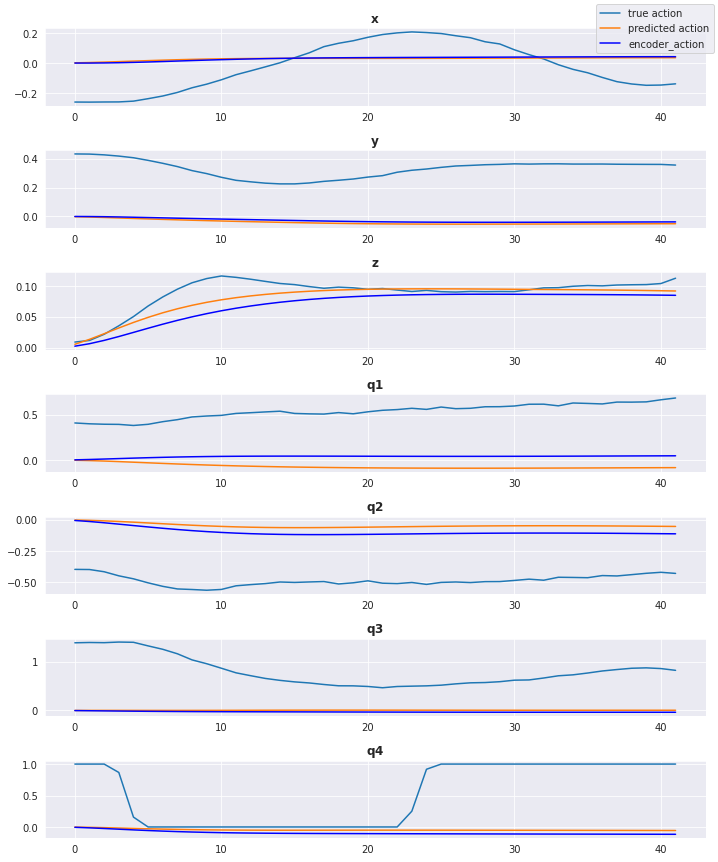

In [19]:
#@title Plot timeseries of state/action tracking over time - xyz q1234 gripper
import seaborn as sns
sns.set_style("darkgrid")

idx = 7
seq_len = int(seq_lens[idx])
x = np.arange(seq_len)
labels = ['x','y','z','q1','q2','q3','q4','gripper']
fig, axes = plt.subplots(ACT_DIM, 1, figsize=(10,12), squeeze=True)
for i in range(ACT_DIM):
    #sns.lineplot(x, acts[idx,:seq_len,i], color='r', ax=axes[i])
    axes[i].plot(acts[idx,:seq_len,i])
    axes[i].plot(pred_acts[idx, :seq_len,i])
    #sns.lineplot(x, pred_acts[idx, :seq_len,i], color='g', ax=axes[i])
    if not GCBC:
      sns.lineplot(x, enc_act_distrib[idx, :seq_len,i], color='b', ax=axes[i])
      axes[i].set_title(f'$\\bf{labels[i]}$')
    
fig.legend( ('true action', 'predicted action', 'encoder_action'))    
plt.tight_layout()
plt.show()

In [ ]:
colors_dict = {
 'press button': [1,0,0], # red
 'dial off': [0.2, 0.6, 0.2], # green
 'dial on': [0, 0.8, 0], # bolder green
 'door left':[0.6, 0, 0.8], # purple #9900cc
 'door right':[0.8,0.2,0.99],
 'drawer in':[0.4, 0.2,0], # browns #cc9900
 'drawer out':[0.8, 0.6, 0],
 'block in drawer':[1,1,0.4], # yellows
 'block out of drawer':[1,0.8,0.8],
 'block in cupboard left':[1,0.4,1], #brighter purple #ff66ff
 'block in cupboard right':[0.8, 0.4, 1.0], # lighter purpple #cc33ff,,
 'block out of cupboard left':[0.6, 0.4, 1.0], # bluer purpe #9966ff
 'block out of cupboard right':[0.6, 0.6, 1.0], # bluer lilac #9999ff
 'pick place': [0, 0.7, 1.0], # #00BFFF eveertything from here down is shades of blue
 'knock down block': [0.1, 0.6, 0.8],
 'stand up block': [0.05, 0.4, 0.8], ##0E61D1
 'lift up': [0.05, 0.2, 0.7], # #1432BA
 'take down':[0.03, 0.001, 0.6], # #1B03A3
 'rotate block left': [0.2, 0.8, 0.8],
 'rotate block right':[0.2, 0.8, 1.0] 
}

def get_labelled_trajs():
    test_labels = np.load(TEST_DIR + 'trajectory_labels.npz', allow_pickle=True)['trajectory_labels']
    acts,obs,labels, colors = [], [], [], []

    for k,v in test_labels.flatten()[0].items():
        folder = k.split('states_and_ims/')[1].split('/')[0]
        start = int(k.split('env_states/')[1].split('/')[0].strip('.bullet'))
        data = np.load(TEST_DIR+'obs_act_etc/'+folder+'/data.npz')
        traj_len = 40
        end = start + traj_len #min(len(data['acts_rpy'])-1,start+traj_len )
        traj_acts = data['acts_rpy'][start:end]
        traj_obs = data['obs_rpy'][start:end]
        obs.append(traj_obs),acts.append(traj_acts),labels.append(v), colors.append(colors_dict[v])

    return np.array(acts), np.array(obs), labels, colors


import umap
reducer = umap.UMAP(metric='cosine', random_state=42)

def project_labelled_latents(reducer, z_enc):
    ''' Todo: may need to rethink vector averaging here... '''
    reducer.fit(z_enc)
    z_enc_embed = reducer.transform(z_enc)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(z_enc_embed[:, 0], z_enc_embed[:, 1], s=7, label='z_enc', c = colors)
    ax.set_aspect('equal', 'datalim')
    ax.legend(loc='upper left')
    plt.axis('off')
    plt.tight_layout()
    return fig\

obs, acts, labels, colors = get_labelled_trajs()
z = encoder((obs,acts))
o = project_labelled_latents(reducer, z.sample())

In [69]:
env.panda.close()

closing


In [440]:
# string constructors



In [24]:
import gym
import time
import seaborn as sns
import pandaRL
if arm == 'UR5':
    if JOINTS and RELATIVE:
        env = gym.make('UR5PlayRelJoints1Obj-v0')
    elif JOINTS and not RELATIVE:
        env = gym.make('UR5PlayAbsJoints1Obj-v0')
        #env = gym.make('pandaPlayJoints-v0')
    elif not JOINTS and RELATIVE and QUAT:
        env = gym.make('UR5PlayRel1Obj-v0')
    elif not JOINTS and RELATIVE and not QUAT:
        env = gym.make('UR5PlayRelRPY1Obj-v0')
    elif not JOINTS and not RELATIVE and not QUAT:
        env = gym.make('UR5PlayAbsRPY1Obj-v0')
    else:
        env = gym.make('UR5Play1Obj-v0')
else:
    if JOINTS and RELATIVE:
        env = gym.make('pandaPlayRelJoints1Obj-v0')
    elif JOINTS and not RELATIVE:
        env = gym.make('pandaPlayAbsJoints1Obj-v0')
        #env = gym.make('pandaPlayJoints-v0')
    elif not JOINTS and RELATIVE and QUAT:
        env = gym.make('pandaPlayRel1Obj-v0')
    elif not JOINTS and RELATIVE and not QUAT:
        env = gym.make('pandaPlayRelRPY1Obj-v0')
    elif not JOINTS and not RELATIVE and not QUAT:
        env = gym.make('pandaPlayAbsRPY1Obj-v0')
    else:
        env = gym.make('pandaPlay1Obj-v0')
        
env.render('human')
env.reset()

current_dir=/home/sholto/Desktop/AI/pandaRL/pandaRL/envs
current_dir=/home/sholto/Desktop/AI/pandaRL/pandaRL/envs


/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN',

/home/sholto/Desktop/AI/pandaRL/pandaRL/envs


{'observation': array([-7.3485315e-02,  7.2982401e-02,  2.4746183e-01,  8.1980421e-04,
         4.6249856e-03,  1.3650469e-04,  9.9998897e-01,  0.0000000e+00,
        -5.1696606e-02,  2.9262793e-01, -4.2078631e-05,  9.8784039e-05,
         2.0380766e-04, -2.7906941e-02,  9.9961048e-01,  7.2899341e-17,
        -2.4305612e-26,  1.1222222e-02,  0.0000000e+00], dtype=float32),
 'achieved_goal': array([-5.1696606e-02,  2.9262793e-01, -4.2078631e-05,  9.8784039e-05,
         2.0380766e-04, -2.7906941e-02,  9.9961048e-01,  7.2899341e-17,
        -2.4305612e-26,  1.1222222e-02,  0.0000000e+00], dtype=float32),
 'desired_goal': array([0.12879974, 0.07664972, 0.09168812], dtype=float32),
 'controllable_achieved_goal': array([-0.07348531,  0.0729824 ,  0.24746183,  0.        ], dtype=float32),
 'full_positional_state': array([-7.3485315e-02,  7.2982401e-02,  2.4746183e-01,  8.1980421e-04,
         4.6249856e-03,  1.3650469e-04,  9.9998897e-01,  0.0000000e+00,
        -5.1696606e-02,  2.9262793e-0

In [36]:
model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM, 'training':False, 'return_state':True}
if PROBABILISTIC:
    actor = create_actor(**model_params, GCBC=GCBC, num_distribs=3)
else:
    actor = create_actor(**model_params, GCBC=GCBC)


In [86]:
path = 'ABS_RPY_GCBC_UR5' #ABS_RPY_GCBC_UR5 #ABS_RPY_GCBC_2hrs
#path = ''REL_RPY_GCBC_UR5v2' 
actor.load_weights(f'saved_models/{path}/model.h5')

In [37]:
import time
GCBC = True
def clip_action(a):
    #a[0:7] = np.clip(a[0:7], -0.05, 0.05)
    return a

def get_closest_idx(point, idxs):
    
    
    closest_idx = idxs[0]
    best_diff = max(idxs)
    for i in idxs:
        diff = abs(point - i)
        if diff < best_diff:
            closest_idx = i
            best_diff = diff
    return closest_idx

def get_closest_init_state(f, start_index):
    
    potential_start_points = glob.glob(DATA_DIR+'/states_and_ims/'+str(f)+'/env_states/*.bullet')
    potential_start_idxs = [int(x.replace('.bullet','').replace(f"{DATA_DIR}/states_and_ims/{str(f)}/env_states/", "")) for x in potential_start_points]
    closest_start = get_closest_idx(int(start_index), potential_start_idxs)
    return closest_start, f"{DATA_DIR}/states_and_ims/{str(f)}/env_states/{closest_start}.bullet"

def get_expert_actions(data, closest_start, traj_len):
    if JOINTS:
        if RELATIVE:
            
            a_true = np.concatenate([data['target_poses'][closest_start:closest_start+traj_len,:6] - data['joint_poses'][closest_start:closest_start+traj_len,:6],
                                      np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)], axis=1)
        else:
            
            a_true = np.concatenate([data['target_poses'][closest_start:closest_start+traj_len,:],
                                      np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)],axis = 1)
    else:
        if QUAT:
            if RELATIVE:
                a_true = np.concatenate([data['acts'][closest_start:closest_start+traj_len,:7] - data['obs'][closest_start:closest_start+traj_len,:7], 
                                         np.expand_dims(data['acts'][closest_start:closest_start+traj_len,7],1)], axis = 1)
            else:
                a_true = data['acts'] 
        else:
            if RELATIVE:
                a_true = data['acts_rpy_rel'][closest_start:closest_start+traj_len,:]
            else:
                a_true = data['acts_rpy'][closest_start:closest_start+traj_len,:]
    return a_true
    
    
def warm_up(actor, o , goal, z = None):
    for i in range(0,10):
            if GCBC:
                a,_,state = actor((o, goal))
            else:
                a = actor((o, z,goal))
                
def get_true_obs(data, closest_start, traj_len):
    ''' gets the actual obs so we can test the encoder actions with them '''
    traj_len += 1 # because we need all the obs, which includes one more ob than there are actions (as that ob will be produced by the final action occuring)
    if USE_QUAT_OBS:
        o = data['obs'][closest_start:closest_start+traj_len,:]
    else:
        o = data['obs_rpy'][closest_start:closest_start+traj_len,:]
    if JOINTS:
        o = np.concatenate([o, data['joints'][closest_start:closest_start+traj_len,:7]])
    
    o = tf.expand_dims(o,0)
        
    if VELOCITY:
        raise NotImplemented
    
    #obs = (obs - hyper_params['means_obs'])/hyper_params['stds_obs']
    return o
    
                
def flatten_obs(obs_dict, record_o_buff=None):
    '''
    Get the right format and flatten, e.g get joints states, velcoities, rpy or quat etc depending on what the
    net was trained on
    Also appends it to record_o_buff to record the true obs
    '''
    if USE_QUAT_OBS:
        o = obs_dict['observation']
    else:
        o = obs_dict['obs_rpy']
    if JOINTS:
        o = tf.expand_dims(tf.expand_dims(np.concatenate([o, obs_dict['joints'][:7]]),0),0)
    else:
        o = tf.expand_dims(tf.expand_dims(o,0),0)
        
    if VELOCITY:
        o = tf.concat([tf.cast(o, tf.float32),tf.expand_dims(tf.expand_dims(tf.cast(obs_dict['velocity'],tf.float32),0),0)], axis = -1)
    
    #obs = (obs - hyper_params['means_obs'])/hyper_params['stds_obs']
    if record_o_buff is not None:
        record_o_buff.append(o)
    return o

def initialise_subsequence(data):
    states, acts, goals, seq_lens, masks, pth, tsteps,_,_ = [data[k] for k in data.keys()]
    start_idx = str(int(tsteps[idx,0]))
    traj_len = len(np.where(masks[idx] == 1)[0])-1
    f = int(pth[idx,0])
    
    print(int(pth[idx,0]), int(tsteps[idx,0]))
    print(str(int(pth[idx,0]))+str(int(tsteps[idx,0])) )
    #print(PYBULLET_DATA_DIR +'states_and_ims/'+str(int(pth[idx,0]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')
    closest_start, start_path = get_closest_init_state(f, start_idx)
    print(start_path)
    try:
        env.delete_sub_goal()
    except:
        pass
    env.p.restoreState(fileName=start_path)
    data = np.load(DATA_DIR+'obs_act_etc/'+str(f)+'/data.npz')
    a_true = get_expert_actions(data, closest_start, traj_len)
    o_true = get_true_obs(data, closest_start, traj_len)
    goal = data['achieved_goals'][closest_start + traj_len, :]
    env.visualise_sub_goal(np.squeeze(goal), 'achieved_goal')
    goal = tf.expand_dims(tf.expand_dims(goal, 0),0)
    #goal = (goal - hyper_params['means_goals'])/hyper_params['stds_goals']
    state = env.panda.calc_state()
    print(state['achieved_goal'] - goal)
    return goal, a_true, o_true, traj_len, state

def choose_action(actor, o, goal, states=None, a_pred=None, a_true=None, replay=False, i=0):
    if GCBC:
        a,_,state = actor((o, goal))
        
        if PROBABILISTIC:
            a = a.sample().numpy().squeeze()
        else:
            a = a.numpy().squeeze()
        if states is not None:
            states.append(state)
        if a_pred is not None:
            a_pred.append(a)
        pass
    else:
        a = actor((o, z,goal)).numpy().squeeze()
        if a_pred is not None:
            a_pred.append(a)

    if replay or i < 0:
        a=a_true[i, :] 
    return a

def test_subsequences(data, idx, retries = 1, replay=False, replan_horizon=30):
    
    goal, a_true, o_true, traj_len, state = initialise_subsequence(data)
    
    a_pred = []
    states = []
    record_o_buff = []
    
    o = flatten_obs(state, record_o_buff)
    
    for j in range(0,retries):
        if GCBC:
            z = None
        else:
            plan, _ = planner((o[0], goal[0]))
            z = tf.expand_dims(plan.sample(),0)
        actor.reset_states()
        
        if replay:
            replan_horizon = traj_len

        #warm_up(actor, o, goal, z)
        
        for i in range(0, replan_horizon):
            a = choose_action(actor, o, goal, states, a_pred, a_true, replay, i)
            o, r, d, _ = env.step(a)
            # put the o here
            o = flatten_obs(o, record_o_buff)
            
            
                
            
    
    return np.array(a_true), np.array(a_pred), states, o_true, np.squeeze(np.array(record_o_buff))

In [38]:
# Lets plot pred actions vs true actions
v_it = iter(test_dataset.repeat(-1))
DATA_DIR = TEST_DIR


In [39]:
# for i in range(0,BATCH_SIZE_PER_REPLICA):
data = v_it.next()
idx = np.random.choice(BATCH_SIZE_PER_REPLICA)

#''

In [40]:
true, pred, states,o_true, o_actual = test_subsequences(data, idx, retries = 1, replay=True)

1 1915
11915
data_collection/collected_data/UR5_25Hz_test_suite//states_and_ims/1/env_states/1920.bullet
8
9
10
tf.Tensor(
[[[-0.13601698 -0.30412135 -0.31482822 -0.01389109  0.17170459
   -0.04742473  0.07839221  0.          0.          0.
    0.        ]]], shape=(1, 1, 11), dtype=float32)


In [66]:
#time.sleep(0.25)
true, pred, states, o_true, o_actual  = test_subsequences(data, idx, retries = 2, replay=False)

1 1204
11204
data_collection/collected_data/UR5_25Hz_test_suite//states_and_ims/1/env_states/1200.bullet
8
9
10
tf.Tensor(
[[[-0.01246276  0.00771217  0.05410607 -0.01457816  0.04282855
   -0.4322482  -0.11152226  0.          0.          0.
    0.        ]]], shape=(1, 1, 11), dtype=float32)


In [70]:
for i in range(0,10):
    data = v_it.next()
    idx = np.random.choice(BATCH_SIZE_PER_REPLICA)
    true, pred, states,o_true, o_actual = test_subsequences(data, idx, retries = 1, replay=True)
    true, pred, states,o_true, o_actual = test_subsequences(data, idx, retries = 2, replay=False)

1 1949
11949
data_collection/collected_data/UR5_25Hz_test_suite//states_and_ims/1/env_states/1950.bullet
8
9
10
tf.Tensor(
[[[-0.06631868 -0.20031591  0.03291887  0.0141366  -0.20536561
   -0.08014309  0.06868726  0.          0.          0.
    0.        ]]], shape=(1, 1, 11), dtype=float32)
1 1949
11949
data_collection/collected_data/UR5_25Hz_test_suite//states_and_ims/1/env_states/1950.bullet
8
9
10
tf.Tensor(
[[[-0.06631868 -0.20031591  0.03291887  0.0141366  -0.20536561
   -0.08014309  0.06868726  0.          0.          0.
    0.        ]]], shape=(1, 1, 11), dtype=float32)
1 688
1688
data_collection/collected_data/UR5_25Hz_test_suite//states_and_ims/1/env_states/690.bullet
8
9
10
tf.Tensor(
[[[ 1.3858080e-05  5.0663948e-05 -7.7410732e-08  4.2996362e-07
   -1.6108243e-07 -2.7931528e-04  1.6093254e-06  0.0000000e+00
    2.7386707e-01 -1.3681538e-03  0.0000000e+00]]], shape=(1, 1, 11), dtype=float32)
1 688
1688
data_collection/collected_data/UR5_25Hz_test_suite//states_and_ims/1/env

In [87]:
import tests
from importlib import reload
reload(tests)

for test in tests.test_list:
    # get the goal and reset to the init position
    print(f"\n Test: {test.__name__}")
    goal = tf.expand_dims(tf.expand_dims(test(env),0),0)
    state = env.panda.calc_state()
    o = flatten_obs(state)
        
    initial_ag = state['achieved_goal']
    
    try:
        env.delete_sub_goal()
    except:
        pass
    
    env.visualise_sub_goal(np.squeeze(goal), 'achieved_goal')

    retries = 2
    for i in range(0,retries):
        if not GCBC:
            plan, _ = planner((o[0], goal[0]))
            z = tf.expand_dims(plan.sample(),0)
        actor.reset_states()
        for i in range(0, 40):
            a = choose_action(actor, o, goal)
            #time.sleep(0.02)
            o, r, d, _ = env.step(a)
            o = flatten_obs(o)
            
            
    state = env.panda.calc_state()
    final_ag = state['achieved_goal']
    
    tests.measure_progress(initial_ag, final_ag, np.squeeze(goal.numpy()))
            
    


 Test: door_left
8
9
10
0/1 [............................................] - ETA: 0s - L1: 0.0380
 Test: door_right
8
9
10
0/1 [=========>....................] - ETA: 0s - L1: 0.0206
 Test: open_drawer
8
9
10
-5/1 [.......................................................................................................................................................................................................] - ETA: 0s - L1: 0.0707
 Test: close_drawer
8
9
10
-1/1 [....................................................................] - ETA: 0s - L1: 0.0242
 Test: push_left
8
9
10
-7/1 [...........................................................................................................................................................................................................................................................................] - ETA: 0s - L1: 0.1961
 Test: push_right
8
9
10
-3/1 [.................................................................................

KeyboardInterrupt: 

# env.panda.delete_sub_goal()

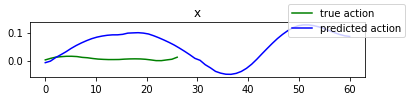

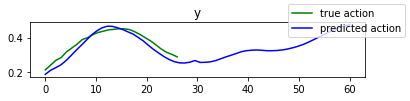

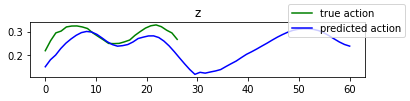

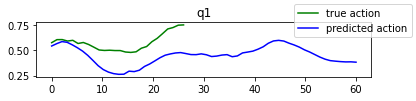

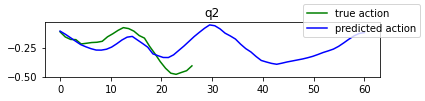

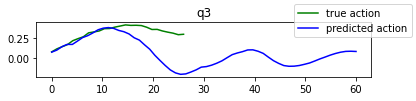

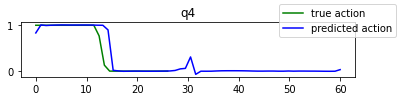

In [71]:
length_true = len(true)
length_pred = len(pred)
actions_space = true.shape[-1]
x_true = np.linspace(0, length_true, num=length_true) 
x_pred = np.linspace(0, length_pred, num=length_pred) 
if JOINTS:
    labels = ['j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'j7', 'gripper']
else:
    labels = ['x','y','z','q1','q2','q3','q4','gripper']
for i in range(0,actions_space):
    fig, axes = plt.subplots(1, 1, figsize=(6,1.0), squeeze=False)
    # One Model
    axes[0,0].plot(x_true,true[:,i],'green')
    axes[0,0].plot(x_pred,pred[:,i], 'b')
    fig.legend( ('true action', 'predicted action'))
   
    plt.title(labels[i])
    plt.show()

In [105]:
state_evolve = np.squeeze(np.array(states))

In [106]:
sns.heatmap(state_evolve.T)

ValueError: Must pass 2-d input

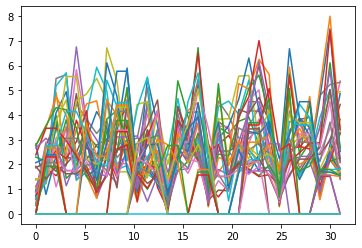

In [107]:
plt.plot(np.linspace(0,len(states)-1,len(states)-1),np.linalg.norm(state_evolve[1:,:] - state_evolve[:-1,:], axis=-1))

In [28]:

for i in range(0,20):
    data = v_it.next()
    idx = np.random.choice(BATCH_SIZE_PER_REPLICA)
    true, pred, _ = test_subsequences(data, idx, retries = 1, replay=True)
    #true, pred, states = test_subsequences(data, idx, retries = 1, replay=False)

7 3085
73085
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3085.bullet
7 3008
73008
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3008.bullet
7 3034
73034
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3034.bullet
7 3169
73169
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3169.bullet
7 2984
72984
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/2984.bullet
7 2969
72969
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/2969.bullet
7 3250
73250
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3250.bullet
7 3272
73272
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3272.bullet
7 3267
73267
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3267.bullet
7 3206
73206
data_collection/collected_data/new_ori_one_obj/states_and_ims/7/env_states/3206.bullet


# Transition Model Experiments

In [18]:
model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM, 'training':False}
if PROBABILISTIC:
    actor_stateful = create_actor(**model_params, GCBC=GCBC, num_distribs=3)
else:
    actor_stateful = create_actor(**model_params, GCBC=GCBC)

In [28]:
%%time
actor_stateful.set_weights(actor.get_weights())

CPU times: user 530 ms, sys: 220 ms, total: 751 ms
Wall time: 370 ms


In [28]:
# Create a transition model, input obs, act, output obs
import tensorflow_addons as tfa

def create_transition_model(layer_size=512):
    # params #
    batch_size = None

    # Input #
    o = Input(shape=(OBS_DIM,), batch_size=batch_size, dtype=tf.float32, name='initial_obs') # has arm state
    a = Input(shape=(ACT_DIM,), batch_size=batch_size, dtype=tf.float32, name='goal_obs') # does not have arm state

    # Layers #
    x = Concatenate(axis=-1)([o,a])
    x = Masking(mask_value=0.)(x)
    x = Dense(layer_size, activation="relu", name='layer_1')(x)
    x = Dense(layer_size, activation="relu", name='layer_2')(x)
    x = Dense(layer_size, activation="relu", name='layer_3')(x)
    o_next = Dense(OBS_DIM, name='layer_4')(x)
    
    return Model([o, a], o_next)

def make_model_batch(states, acts):
    s = states[:, :-1,:]
    a = acts[:, :-1, :]
    s_next = states[:, 1:, :]
    B,T,D = s.shape
    s = tf.reshape(s, (B*T, D))
    a = tf.reshape(a, (B*T, -1))
    s_next = tf.reshape(s_next, (B*T, D))
    return s, a, s_next


model = create_transition_model()
model_optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=1e-4)
t_it = iter(train_dataset.repeat(-1))
v_it = iter(valid_dataset.repeat(-1))


In [29]:

# Take a batch from t_it, regress next obs to obs/act


total_steps = 10000
t = 0
steps = []
t_losses = []
v_losses = []
   
    
def step(d):
    s,a, _,_,_,_,_ = [d[k] for k in d.keys()]
    s,a,s_next = make_model_batch(s,a)
    s_pred = model((s,a))
    return tf.reduce_mean(tf.keras.losses.MAE(s_next, s_pred))

def train_step():
    with tf.GradientTape() as tape:
        d = t_it.next()
        loss = step(d)
        gradients = tape.gradient(loss, model.trainable_variables)
        model_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def valid_step():
    d = v_it.next()
    return step(d)


while(t<total_steps):
    
    t_loss = train_step()
    v_loss = valid_step()
    if t % 500 == 0:
        t_losses.append(t_loss)
        v_losses.append(v_loss)
        steps.append(t)
        print(t, v_loss.numpy())
        
    t += 1

0 0.2616796
500 0.08140578
1000 0.080035
1500 0.07606537
2000 0.063986965
2500 0.06395352
3000 0.061576404
3500 0.06351275


KeyboardInterrupt: 

In [30]:
def plot(array):
    plt.plot(np.linspace(0,len(array),len(array)),np.linalg.norm(array, axis=-1))

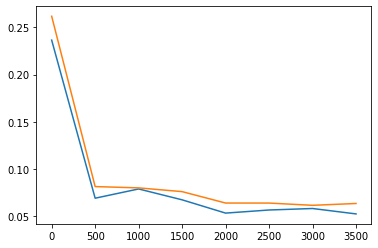

In [31]:
plt.plot(steps, t_losses)
plt.plot(steps, v_losses)

In [55]:


# Using stateful actor, play out a sequence from our trajectory bank
import time

def test_subsequences(data, idx, retries = 3, replay=False, replan_interval=20):
    
    
    states, acts, goals, seq_lens, masks, pth, tsteps = [data[k] for k in data.keys()]
    
    
    start_idx = str(int(tsteps[idx,0]))
    traj_end = len(np.where(masks[idx] == 1)[0])-1
    print(int(pth[idx,0]), int(tsteps[idx,0]))
    print(str(int(pth[idx,0]))+str(int(tsteps[idx,0])) )
    print(PYBULLET_DATA_DIR +'states_and_ims/'+str(int(pth[idx,0]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')

    env.p.restoreState(fileName=PYBULLET_DATA_DIR +'states_and_ims/'+str(int(pth[idx,0]))+'/env_states/'+str(int(tsteps[idx,0]))+'.bullet')
    state = env.panda.calc_state()
    if JOINTS:
        o = tf.expand_dims(tf.expand_dims(np.concatenate([state['observation'], state['joints'][:7]]),0),0)
    else:
        o = tf.expand_dims(tf.expand_dims(state['observation'],0),0)
    #print(states)
    #print(o.shape, o_p.shape, states.shape)
    #print(o, '-------------------', o_p)
    goal = goals[idx, traj_end,:]
    goal = tf.expand_dims(tf.expand_dims(goal, 0),0)
    
    if VELOCITY:
        o = tf.concat([tf.cast(o, tf.float32),tf.expand_dims(tf.expand_dims(tf.cast(state['velocity'],tf.float32),0),0)], axis = -1)
    
    if replay:
        retries = 1
    o_p = tf.expand_dims(tf.expand_dims(states[idx,0],0),0)
    a_true =  acts[idx, :traj_end]
    a_pred = []
    o_ins, a_ins = [],[]
    o_trues = []
    o_preds= []
    o_pred = tf.squeeze(o,0)
    for j in range(0,retries):
        if not GCBC:
            plan, _ = planner((o[0], goal[0]))
            z = tf.expand_dims(plan.sample(),0)
        actor.reset_states()
        if not replay:
            replan_horizon = traj_end
        else:
            replan_horizon = traj_end
            
        for i in range(0, replan_horizon):

            
            if GCBC:
                a,_,_ = actor((o, goal))
                a = a.numpy().squeeze()
                a_pred.append(a)
            else:
                a = actor((o, z,goal)).numpy().squeeze()
                a_pred.append(a)
                
            if replay or i < 0:
                a=a_true[i, :] # test whether a good init state would help by visualising the first 5 steps
            
#             o_ins.append(tf.squeeze(o,0)), a_ins.append(tf.expand_dims(a,0))
#             o_pred = model((tf.squeeze(o,0),tf.expand_dims(a,0)))
            o_ins.append(tf.squeeze(o,0)), a_ins.append(tf.expand_dims(a,0))
            o_pred = model((o_pred,tf.expand_dims(a,0)))

            env.visualise_sub_goal(np.squeeze(o_pred))
            o, r, d, _ = env.step(a)
            vel= tf.expand_dims(tf.expand_dims(tf.cast(o['velocity'],tf.float32),0),0)
            if JOINTS:
                o = tf.expand_dims(tf.expand_dims(np.concatenate([o['observation'],o['joints'][:7]]), 0),0)
            else:
                o = tf.expand_dims(tf.expand_dims(o['observation'], 0),0)
                
            if VELOCITY:
                o = tf.concat([tf.cast(o, tf.float32),vel], axis = -1)
                
            o_preds.append(o_pred.numpy())
            o_trues.append(o.numpy())
            
    return np.array(a_true), np.array(a_pred), np.squeeze(np.array(o_trues)), np.squeeze(np.array(o_preds)), np.array(o_ins), np.array(a_ins)
# Feed the actions through transition model and take a few gradient steps until it was more like what actually happened

# Take loss between model predicted state and desired state for all steps, update our actor

# rerun, if its better, then update the main model, otherwise, reset this one to main



In [59]:
env.visualise_sub_goal(np.squeeze(o_pred))
env.panda.delete_sub_goal()
env.panda.sub_goals=None

In [51]:
data = t_it.next()
idx = np.random.choice(BATCH_SIZE_PER_REPLICA)

In [60]:
true, pred, o_true, o_pred, o_in, a_in = test_subsequences(data, idx, retries = 1, replay=True)
pred_diffs = np.squeeze(abs(np.squeeze(np.array(o_true)) - np.squeeze(np.array(o_pred))))

16 4709
164709
data_collection/collected_data/one_obj_play/states_and_ims/16/env_states/4709.bullet
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18
8
15
15
16
17
18


In [42]:
pred_diffs

array([[1.33662634e-02, 9.50123370e-03, 8.20809603e-03, 2.92086601e-03,
        2.78563425e-02, 1.86027586e-03, 7.22116232e-03, 8.85668769e-03,
        1.79850720e-02, 9.79271531e-03, 4.73928452e-03, 1.24136209e-02,
        5.39344549e-03, 1.91547275e-02, 8.27729702e-04, 9.51879844e-03,
        1.76945329e-02, 1.04417559e-02, 7.15146679e-03, 1.40375435e-01,
        1.01133101e-02, 4.39243138e-01, 6.38005733e-01, 3.39920908e-01,
        1.72276512e-01],
       [2.40480099e-02, 9.75231826e-03, 1.86058283e-02, 3.43033671e-03,
        2.56024897e-02, 1.98885500e-02, 6.10744953e-03, 8.42196867e-03,
        1.43989362e-02, 2.14907825e-02, 4.93970513e-03, 4.52691317e-03,
        1.65122747e-02, 2.27601528e-02, 4.68754768e-03, 9.96239483e-04,
        1.74840987e-02, 1.55081879e-02, 5.45195583e-03, 6.03234880e-02,
        1.52027667e-01, 5.31375110e-02, 1.43086195e+00, 1.01110697e+00,
        7.75173366e-01],
       [1.15349442e-02, 5.93468547e-04, 1.58793777e-02, 1.01437271e-02,
        1.5622

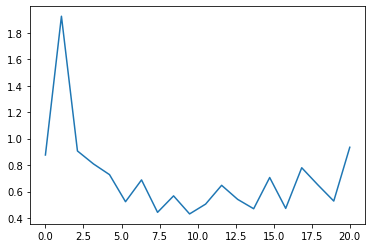

In [43]:
plot(pred_diffs)

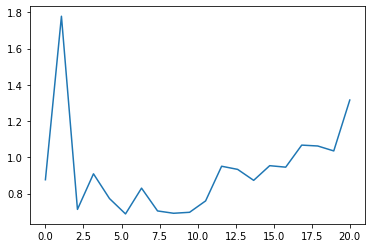

In [44]:
o = o_in[0]
simulated_o = []
for i in range(0, len(a_in)):
    o = model((o, a_in[i]))
    simulated_o.append(o)
    
pred_diffs = np.squeeze(abs(np.squeeze(np.array(o_true)) - np.squeeze(np.array(simulated_o))))
plot(pred_diffs)

In [462]:
# now, optimize the model so that it is better here
def model_update_step(o_in, a_in, o_true):
    with tf.GradientTape() as tape:
        o_pred = model((np.squeeze(o_in),np.squeeze(a_in)))
        print(o_pred.shape, o_true.shape)
        loss_time_wise = tf.keras.losses.MAE(o_pred, o_true)
        
        gradients = tape.gradient(tf.reduce_mean(loss_time_wise), model.trainable_variables)
        model_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_time_wise

In [472]:
np.array(simulated_o[:-1]).shape, a_in.shape, o_true.shape

((29, 1, 26), (30, 1, 8), (30, 26))

(30, 26) (30, 26)


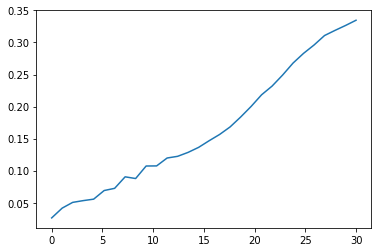

In [475]:
error = model_update_step(np.array(simulated_o),a_in, o_true)
plt.plot(np.linspace(0,len(error),len(error)),error)

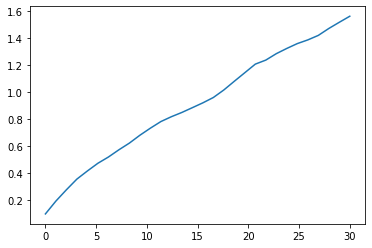

In [476]:
o = o_in[0]
simulated_o = []
for i in range(0, len(a_in)):
    o = model((o, a_in[i]))
    simulated_o.append(o)
    
pred_diffs = np.squeeze(abs(np.squeeze(np.array(o_true)) - np.squeeze(np.array(simulated_o))))
plot(pred_diffs)def create_transition_model(layer_size=512):
    # params #
    batch_size = None

    # Input #
    o = Input(shape=(OBS_DIM,), batch_size=batch_size, dtype=tf.float32, name='initial_obs') # has arm state
    a = Input(shape=(ACT_DIM,), batch_size=batch_size, dtype=tf.float32, name='goal_obs') # does not have arm state

    # Layers #
    x = Concatenate(axis=-1)([o,a])
    x = Masking(mask_value=0.)(x)
    x = Dense(layer_size, activation="relu", name='layer_1')(x)
    x = Dense(layer_size, activation="relu", name='layer_2')(x)
    x = Dense(layer_size, activation="relu", name='layer_3')(x)
    o_next = Dense(OBS_DIM, name='layer_4')(x)
    
    return Model([o, a], o_next)

In [ ]:

def quat_sign_flip(a):
    for i in range(1,len(a)):
        quat = a[i,3:7]
        last_quat = a[i-1,3:7]
        if (np.sign(quat)== -np.sign(last_quat)).all(): # i.e, it is an equivalent quaternion
             a[i,3:7] = - a[i,3:7]
    return a 


# Q Value function tests

In [ ]:
def create_q_function(layer_size=512):
    # params #
    batch_size = None

    # Input #
    o = Input(shape=(OBS_DIM,), batch_size=batch_size, dtype=tf.float32, name='initial_obs') # has arm state
    a = Input(shape=(ACT_DIM,), batch_size=batch_size, dtype=tf.float32, name='goal_obs') # does not have arm state

    # Layers #
    x = Concatenate(axis=-1)([o,a])
    x = Masking(mask_value=0.)(x)
    x = Dense(layer_size, activation="relu", name='layer_1')(x)
    x = Dense(layer_size, activation="relu", name='layer_2')(x)
    x = Dense(layer_size, activation="relu", name='layer_3')(x)
    o_next = Dense(OBS_DIM, name='layer_4')(x)
    
    return Model([o, a], o_next)


In [ ]:
# If we do it with a value function
# Discount rewards back through it - maybe using the parallelism guys thing
# then directly use AWR

# If we do it with Q... harder due to LSTM?

# Q values from (s_D, a_D, g_D)
# R from r
# Q' from nn which predicts Pi' from all s 1:,
# 

In [391]:
error

<tf.Tensor: shape=(21,), dtype=float64, numpy=
array([0.12393562, 0.01049713, 0.01037328, 0.01053249, 0.01017937,
       0.00907761, 0.00964357, 0.00983047, 0.00876082, 0.00849668,
       0.00855127, 0.00843039, 0.0092276 , 0.00918092, 0.009084  ,
       0.00929162, 0.01172736, 0.0116516 , 0.01150378, 0.00865179,
       0.00925565])>

In [16]:

import pybullet as p

def create_rpy(acts, idx):
    a = acts[idx, :int(seq_lens[idx])]
    rpys = []
    for i in range(len(a)):
        rpys.append(p.getEulerFromQuaternion(a[i,3:7]))
    xyz = a[:,0:3]
    rpy = np.array(rpys)
    g = np.expand_dims(a[:,-1],1)
    
    return np.concatenate([xyz, rpy, g], -1)
def quat_sign_flip(acts, idx):
    a = acts[idx, :int(seq_lens[idx])]
    angles = [a[0,3:7]]
    for i in range(1,len(a)):
        quat = a[i,3:7]
        last_quat = angles[-1] 
        if (np.sign(quat)== -np.sign(last_quat)).all(): # i.e, it is an equivalent quaternion
            angles.append(-quat)
        else:
            angles.append(quat)
        #print(np.sign(quat), np.sign(last_quat), (np.sign(quat)== -np.sign(last_quat)).all())
    
    #print(xyz.shape, q.shape, g.shape,q)
    return np.concatenate([xyz, q, g], -1)


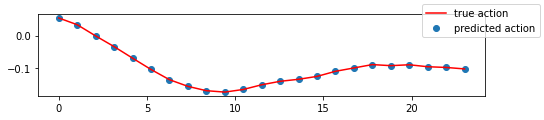

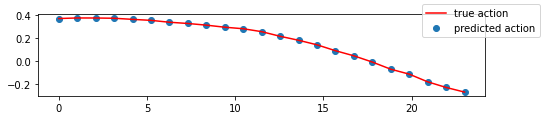

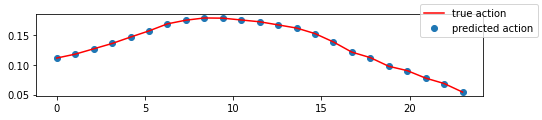

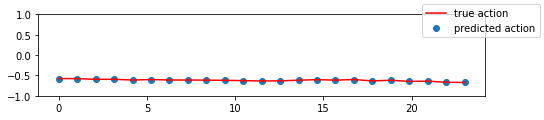

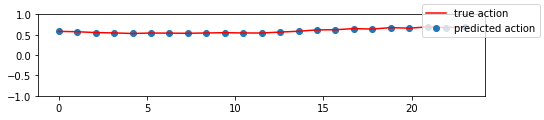

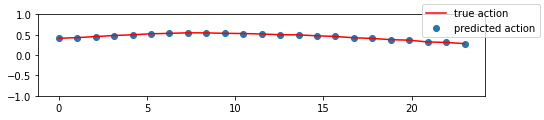

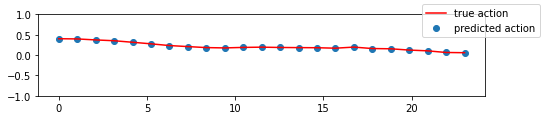

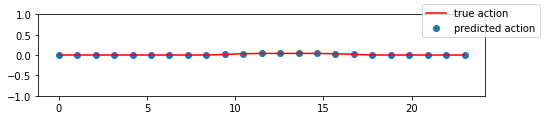

In [19]:

#@title Plot timeseries of state/action tracking over time - xyz q1234 gripper
idx = 15

length = int(seq_lens[idx])
actions_space = acts.shape[2]
x = np.linspace(0, length, num=length) 
for i in range(0,8):
    fig, axes = plt.subplots(1, 1, figsize=(8,1.5), squeeze=False)
    # One Model
    if i >= 3and i < 8:
        axes[0,0].set_ylim([-1,1])
    true = axes[0,0].plot(x,quat_sign_flip(acts,idx)[:,i],'r')
    #predicted = axes[0,0].plot(x,pred_acts[idx, :int(seq_lens[idx]),i], 'b')
    #enc_predicted = axes[0,0].plot(x,enc_act_distrib[idx, :int(seq_lens[idx]),i], 'g')
    true = axes[0,0].scatter(x,quat_sign_flip(acts,idx)[:,i])
    
    fig.legend( ('true action', 'predicted action', 'encoder_action'))
    
    
    plt.show()

In [ ]:
descriptions = {
    1: 'lift up',
    2: 'take down',
    3: 'door left',
    4: 'door right',
    5: 'drawer in',
    6: 'drawer out',
    7: 'pick place',
    8: 'press button',
    9: 'dial on',
    10: 'dial off',
    11: 'rotate block left',
    12: 'rotate block right',
    13: 'stand up block',
    14: 'knock down block',
    15: 'block in cupboard right',
    16: 'block in cupboard left',
    17: 'block in drawer',
    18: 'block out of drawer',
    19: 'block out of cupboard right',
    20: 'block out of cupboard left'
}